## LOAN DEFAULTER PREDICTION

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

## Loading the Data

In [2]:
df = pd.read_csv("Data.csv")
df = df.drop("Id", axis=1)
df.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             252000 non-null  int64 
 1   Age                252000 non-null  int64 
 2   Experience         252000 non-null  int64 
 3   Married/Single     252000 non-null  object
 4   House_Ownership    252000 non-null  object
 5   Car_Ownership      252000 non-null  object
 6   Profession         252000 non-null  object
 7   CITY               252000 non-null  object
 8   STATE              252000 non-null  object
 9   CURRENT_JOB_YRS    252000 non-null  int64 
 10  CURRENT_HOUSE_YRS  252000 non-null  int64 
 11  Risk_Flag          252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 23.1+ MB


In [4]:
df.describe()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


In [5]:
# splitting data into train, validation and test sets to avoid data leakage

from sklearn.model_selection import train_test_split as tts
train, valid_test = tts(df.copy(), test_size=0.2, random_state=42)
valid, test = tts(valid_test.copy(), test_size=0.5, random_state=42)

In [6]:
# creating list of numerical and categorical features

num_cols = [column for column in train.columns if train.dtypes[column] == "int64"]
cat_cols = [column for column in train.columns if train.dtypes[column] == "object"]

print("Numerical Columns : " + str(num_cols))
print("Categorical Columns : " + str(cat_cols))

Numerical Columns : ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag']
Categorical Columns : ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']


## Exploratory Data Analysis

### Numerical Features

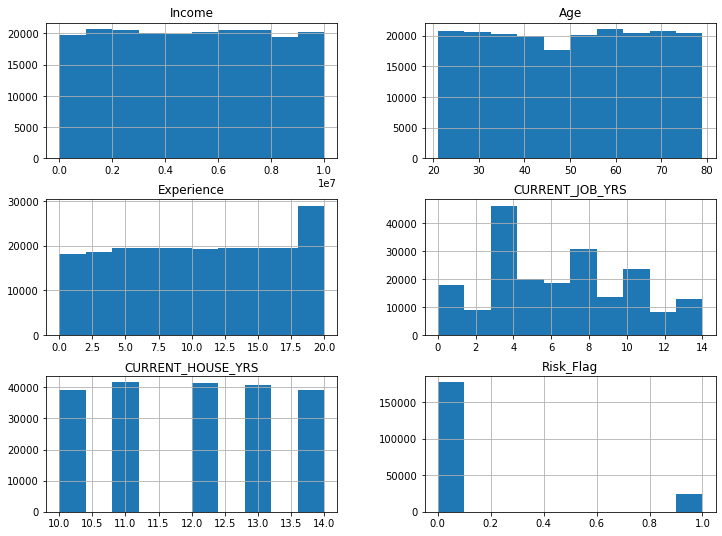

In [7]:
# visualizing the distribution of all numerical features and the label

train.hist(figsize=(12, 9))
plt.show()

##### The distribution of Risk_Flag shows imbalance in classes.
Sampling techniques will be used on the training set to make the classes equal.

[]

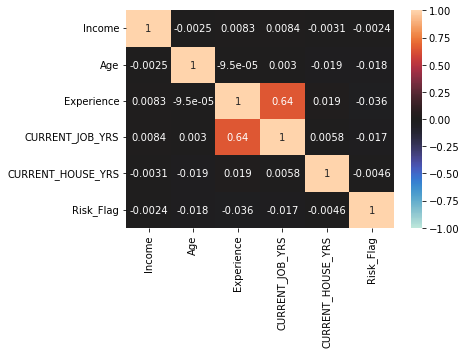

In [8]:
# plotting the correlation matrix using seaborn to check for correlation between numerical features

corr_mat = train.corr()
sns.heatmap(corr_mat, vmin=-1, vmax=1, center=0, annot=True)
plt.plot()

[]

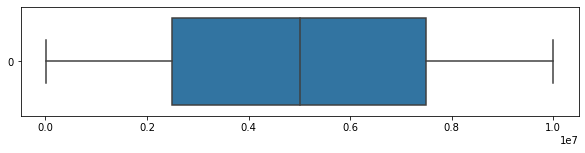

In [9]:
# checking for outliers
# replace 'Income' with any other numerical feature that you need to inspect and re-run the cell

plt.figure(figsize=(10,2))
sns.boxplot(data=train['Income'].values, orient='h') 
plt.plot()

# no feature shows any outliers in the boxplot

### Categorical Features

In [10]:
def print_count_cats(df, columns):
    '''
    print the number of categories in each categorical feature
    '''
    for column in columns:
        count = len(df[column].value_counts())
        print("{0} : {1}".format(column, count))

print_count_cats(train, cat_cols)

Married/Single : 2
House_Ownership : 3
Car_Ownership : 2
Profession : 51
CITY : 317
STATE : 29


## Feature Engineering - Modifying the features

In [11]:
# seperating the features and the label

train_y = train['Risk_Flag'].copy()
train = train.drop('Risk_Flag', axis=1)

valid_y = valid['Risk_Flag'].copy()
valid = valid.drop('Risk_Flag', axis=1)

test_y = test['Risk_Flag'].copy()
test = test.drop('Risk_Flag', axis=1)

### Sampling

In [12]:
# oversampling

from collections import Counter
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(sampling_strategy=0.25)

print("Before sampling: " + str(Counter(train_y)))
train, train_y = sampler.fit_resample(train, train_y)
print("After sampling: " + str(Counter(train_y)))

Before sampling: Counter({0: 176857, 1: 24743})
After sampling: Counter({0: 176857, 1: 44214})


In [13]:
# undersampling

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler(sampling_strategy=1.0)

print("Before sampling: " + str(Counter(train_y)))
train, train_y = sampler.fit_resample(train, train_y)
print("After sampling: " + str(Counter(train_y)))

Before sampling: Counter({0: 176857, 1: 44214})
After sampling: Counter({0: 44214, 1: 44214})


In [14]:
# ordinal encoding on 'Married/Single' feature
from sklearn.preprocessing import OrdinalEncoder

marital_enc = OrdinalEncoder(categories=[['single', 'married']])
train['Married/Single'] = marital_enc.fit_transform(train['Married/Single'].values.reshape(-1, 1))
valid['Married/Single'] = marital_enc.transform(valid['Married/Single'].values.reshape(-1, 1))
test['Married/Single'] = marital_enc.transform(test['Married/Single'].values.reshape(-1, 1))

### Encoding

In [15]:
# ordinal encoding on 'House_Ownership'
# order between the categories may be percieved as norent_noown < rented < owned
house_enc = OrdinalEncoder(categories=[['norent_noown', 'rented', 'owned']])
train['House_Ownership'] = house_enc.fit_transform(train['House_Ownership'].values.reshape(-1, 1))
valid['House_Ownership'] = house_enc.transform(valid['House_Ownership'].values.reshape(-1, 1))
test['House_Ownership'] = house_enc.transform(test['House_Ownership'].values.reshape(-1, 1))

In [16]:
# ordinal encoding on 'Car_Ownership'
car_enc = OrdinalEncoder(categories=[['no', 'yes']])
train['Car_Ownership'] = car_enc.fit_transform(train['Car_Ownership'].values.reshape(-1, 1))
valid['Car_Ownership'] = car_enc.transform(valid['Car_Ownership'].values.reshape(-1, 1))
test['Car_Ownership'] = car_enc.transform(test['Car_Ownership'].values.reshape(-1, 1))

In [17]:
# printing shapes of dataframes before one hot encoding
print(train.shape)
print(valid.shape)
print(test.shape)

(88428, 11)
(25200, 11)
(25200, 11)


In [18]:
# one hot encoding of 'Profession', 'STATE' using pandas
df_combined = pd.get_dummies(train.append([valid, test]), columns=['Profession', 'STATE', 'CITY'],
                            drop_first=True)
train = df_combined.iloc[:train.shape[0], :].copy()
valid = df_combined.iloc[train.shape[0]: train.shape[0] + valid.shape[0], :]
test = df_combined.iloc[train.shape[0] + valid.shape[0]:, :].copy()

In [19]:
# printing shapes of dataframes after one hot encoding to ensure spilts were made correctly
print(train.shape)
print(valid.shape)
print(test.shape)

(88428, 402)
(25200, 402)
(25200, 402)


### Standardization

In [20]:
# performing scaling on all the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_X = scaler.fit_transform(train)
valid_X = scaler.transform(valid)
test_X = scaler.transform(test)

## Creating Models

### Hyperparameter Tuning using Optuna

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, recall_score

# hyperparameter tuning of xgboost using optuna 

def objective(trial):
    # setting search space
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)
    n_estimators = trial.suggest_int("n_estimators", 1000, 5000)
    
    # defining the model
    clf = XGBClassifier(learning_rate=learning_rate, 
                        reg_lambda=reg_lambda,
                        subsample=subsample, 
                        colsample_bytree=colsample_bytree, 
                        max_depth=max_depth, 
                        n_estimators=n_estimators, 
                        use_label_encoder=False,
                        random_state=42)
    
    clf.fit(train_X, train_y, eval_metric='logloss')
    valid_preds = clf.predict(valid_X)
    
    # using ROC AUC Score to choose the best combination of hyperparameters
    score = roc_auc_score(valid_y, valid_preds)
    
    return score

In [22]:
# # This cell is run only when hypertuning using OPTUNA

# # creating study object
# study = optuna.create_study(direction="maximize")

# # optimising the study object
# study.optimize(objective, n_trials=100)

# # Print the result
# best_params = study.best_params
# best_score = study.best_value
# print(f"Best score: {best_score}\n")
# print(f"Optimized parameters: {best_params}\n")

In [23]:
# Optuna results

# scored on roc auc
params = {'learning_rate': 0.22657857685769822, 
                       'reg_lambda': 5.8263201980534444e-08, 
                       'reg_alpha': 6.30631361255538e-05, 
                       'subsample': 0.3678211180860871, 
                       'colsample_bytree': 0.8672653738124343, 
                       'max_depth': 7, 
                       'n_estimators': 4973}

### Training

In [25]:
# training the model

xgb = XGBClassifier(random_state=42, use_label_encoder=False, **params)

xgb.fit(train_X, train_y, eval_metric='logloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8672653738124343, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.22657857685769822, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=4973, n_jobs=16, num_parallel_tree=1,
              random_state=42, reg_alpha=6.30631361255538e-05,
              reg_lambda=5.8263201980534444e-08, scale_pos_weight=1,
              subsample=0.3678211180860871, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

### Evaluating the model

In [26]:
# measuring performance of our model on the test set
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

y_pred = xgb.predict(valid_X)

cm = confusion_matrix(valid_y, y_pred)
print(cm)
print("Recall: " + str(recall_score(valid_y, y_pred)))
print("Precision: " + str(precision_score(valid_y, y_pred)))
print("F1 Score: " + str(f1_score(valid_y, y_pred)))
print("Accuracy: " + str(accuracy_score(valid_y, y_pred)))
print("ROC AUC Score: " + str(roc_auc_score(valid_y, y_pred)))

D:\anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[[19217  2808]
 [  492  2683]]
Recall: 0.8450393700787402
Precision: 0.4886177381169186
F1 Score: 0.6192014770366951
Accuracy: 0.8690476190476191
ROC AUC Score: 0.8587739415660444


## Creating the Final Pipeline

### Creating New Datasets to train and test the pipeline

In [30]:
# Creating new dataset splits
final_train, final_test = tts(df.copy(), test_size=0.1, random_state=42)

# seperating the features and the label
final_train_y = final_train['Risk_Flag'].copy()
final_train_X = final_train.drop('Risk_Flag', axis=1)
final_test_y = final_test['Risk_Flag'].copy()
final_test_X = final_test.drop('Risk_Flag', axis=1)

# Sampling the final training set
oversampler = RandomOverSampler(sampling_strategy=0.25)
print("Before over sampling: " + str(Counter(final_train_y)))
final_train_X, final_train_y = oversampler.fit_resample(final_train_X, final_train_y)
print("After over sampling: " + str(Counter(final_train_y)))

undersampler = RandomUnderSampler(sampling_strategy=1.0)
print("Before under sampling: " + str(Counter(final_train_y)))
final_train_X, final_train_y = undersampler.fit_resample(final_train_X, final_train_y)
print("After under sampling: " + str(Counter(final_train_y)))

Before over sampling: Counter({0: 198943, 1: 27857})
After over sampling: Counter({0: 198943, 1: 49735})
Before under sampling: Counter({0: 198943, 1: 49735})
After under sampling: Counter({0: 49735, 1: 49735})


### Assembling different components

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

marital_enc = OrdinalEncoder(categories=[['single', 'married']])

# order between the categories may be percieved as norent_noown < rented < owned
house_enc = OrdinalEncoder(categories=[['norent_noown', 'rented', 'owned']])

car_enc = OrdinalEncoder(categories=[['no', 'yes']])

enc1hot_profession = enc = OneHotEncoder(handle_unknown='error', drop='first', sparse=False)
enc1hot_state = enc = OneHotEncoder(handle_unknown='error', drop='first', sparse=False)
enc1hot_city = enc = OneHotEncoder(handle_unknown='error', drop='first', sparse=False)


scaler = StandardScaler()

transformers = [
    ('marital_enc', marital_enc, ['Married/Single']),
    ('house_enc', house_enc, ['House_Ownership']),
    ('car_enc', car_enc, ['Car_Ownership']),
    ('enc1hot_profession', enc1hot_profession, ['Profession']),
    ('enc1hot_state', enc1hot_state, ['STATE']),
    ('enc1hot_city', enc1hot_city, ['CITY']),
]

encoding_transformer = ColumnTransformer(transformers=transformers, 
                                        remainder='passthrough', n_jobs=-1)

steps = [
    ('encoding_transformer', encoding_transformer),
    ('scaler', scaler),
    ('xgb_clf', xgb)
]

full_pipeline = Pipeline(steps=steps, verbose=True)

### Training

In [33]:
# training using the pipeline

full_pipeline.fit(final_train_X, final_train_y)

[Pipeline]  (step 1 of 3) Processing encoding_transformer, total=   1.8s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.6s
[23:31:10] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Pipeline] ........... (step 3 of 3) Processing xgb_clf, total=14.7min


Pipeline(steps=[('encoding_transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('marital_enc',
                                                  OrdinalEncoder(categories=[['single',
                                                                              'married']]),
                                                  ['Married/Single']),
                                                 ('house_enc',
                                                  OrdinalEncoder(categories=[['norent_noown',
                                                                              'rented',
                                                                              'owned']]),
                                                  ['House_Ownership']),
                                                 ('car_enc',
                                                  OrdinalEncoder(categories=[['no',
                    

### Testing

In [34]:
# testing the pipeline to ensure everything works correctly

final_y_pred = full_pipeline.predict(final_test_X)

cm = confusion_matrix(final_test_y, final_y_pred)
print(cm)
print("Recall: " + str(recall_score(final_test_y, final_y_pred)))
print("Precision: " + str(precision_score(final_test_y, final_y_pred)))
print("F1 Score: " + str(f1_score(final_test_y, final_y_pred)))
print("Accuracy Score: " + str(accuracy_score(final_test_y, final_y_pred)))
print("ROC AUC score: " + str(roc_auc_score(final_test_y, final_y_pred)))

[[19184  2877]
 [  487  2652]]
Recall: 0.8448550493787831
Precision: 0.47965274009766684
F1 Score: 0.6119058606368252
Accuracy Score: 0.8665079365079366
ROC AUC score: 0.8572219583052748


## Saving the Pipeline in a pickle file

In [36]:
# saving pipeline in pickle file
import pickle

filename = 'my_pipeline.pkl'
with open(filename, 'wb') as file:
    pickle.dump(full_pipeline, file)